In [100]:
import pandas as pd
import numpy as np
import pickle
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, "..")   
from src.gdkm import compute_gdkm_cv_scores, suggest_optimal_pq
from src.plot_util import visualize_gdkm_cv_scores, plot_gdkm_elbow_curve, plot_biclustering_elbow
from src.utils import preprocess_sales_matrix, compute_spectral_biclustering_row_col_cv_scores, compute_spectral_biclustering_row_cv_scores



In [63]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
today_str = datetime.today().strftime("%Y-%m-%d")
today_str

'2025-06-04'

In [46]:
# load
dtype_dict={"id":np.uint32,
            "store_nbr":np.uint8,
            "item_nbr":np.uint32,
            "unit_sales":np.float32
           }
df = pd.read_csv("../output/data/train_top_10_store_10_item.csv", dtype=dtype_dict)
cols = ['date', 'store_item', 'store_nbr', 'item_nbr'] + [c for c in df.columns 
                                  if c not in ('date', 'store_item', 'store_nbr', 'item_nbr')]
df = df[cols]
df.rename(columns={"store_nbr": "store", "item_nbr": "item"}, inplace=True)
df["date"] = pd.to_datetime(df["date"])
df.sort_values("date", inplace=True)
df.reset_index(drop=True, inplace=True)
df.head(5)


/var/folders/w3/d06m5l_97yn4bnxd5t6cgbjr0000gn/T/ipykernel_28920/3612587674.py:7: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../output/data/train_top_10_store_10_item.csv", dtype=dtype_dict)


,date,store_item,store,item,unit_sales,onpromotion
0,2013-01-07,48_502331,48,502331,70.00000,NaN
1,2013-01-07,46_584028,46,584028,304.27301,NaN
2,2013-01-07,3_114790,3,114790,28.00000,NaN
3,2013-01-07,3_305229,3,305229,89.00000,NaN
4,2013-01-07,3_314384,3,314384,106.00000,NaN


In [47]:
df['onpromotion'].unique()

array([nan, False, True], dtype=object)

In [51]:
df["date"] = pd.to_datetime(df["date"])
df["dayofweek"] = df["date"].dt.dayofweek
df["month"] = df["date"].dt.month
df["weekofyear"] = df["date"].dt.isocalendar().week
df

,date,store_item,store,item,unit_sales,onpromotion,dayofweek,month,weekofyear
0,2013-01-07,48_502331,48,502331,70.00000,NaN,0,1,2
1,2013-01-07,46_584028,46,584028,304.27301,NaN,0,1,2
2,2013-01-07,3_114790,3,114790,28.00000,NaN,0,1,2
3,2013-01-07,3_305229,3,305229,89.00000,NaN,0,1,2
4,2013-01-07,3_314384,3,314384,106.00000,NaN,0,1,2
...,...,...,...,...,...,...,...,...,...
167299,2017-08-15,51_567623,51,567623,17.00000,False,1,8,33
167300,2017-08-15,51_581078,51,581078,30.00000,False,1,8,33
167301,2017-08-15,49_567623,49,567623,29.00000,False,1,8,33
167302,2017-08-15,49_502331,49,502331,61.00000,False,1,8,33


In [52]:

# Example: aggregate by dayofweek
clust_df = df.groupby(["store_item", "dayofweek"])["unit_sales"].sum().unstack(fill_value=0)
clust_df

dayofweek,0,1,2,3,4,5,6
store_item,,,,,,,
3_1047679,104473.000000,94406.000000,96164.000000,82776.000000,96191.000000,127381.000000,142048.000000
3_114790,6080.000000,5583.000000,6211.000000,4908.000000,5764.000000,7905.000000,8928.000000
3_305229,15900.000000,13750.000000,17093.000000,12586.000000,14852.000000,16053.000000,16819.000000
3_314384,22721.000000,20674.000000,23415.000000,17440.000000,21586.000000,29785.000000,33913.000000
3_364606,25960.000000,24294.000000,26153.000000,20437.000000,22594.000000,29208.000000,31280.000000
...,...,...,...,...,...,...,...
8_502331,11372.000000,9348.000000,9652.000000,7945.000000,9495.000000,12454.000000,15433.000000
8_567623,4441.000000,3879.000000,3941.000000,3181.000000,3373.000000,5589.000000,6786.000000
8_581078,3476.000000,3495.000000,3810.000000,3304.000000,3536.000000,3793.000000,3585.000000


In [54]:
X, pivot_clean = preprocess_sales_matrix(clust_df)

<string>:22: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead


In [55]:
pivot_clean

dayofweek,0,1,2,3,4,5,6
store_item,,,,,,,
3_1047679,11.556693,11.506032,11.495295,11.452448,11.456778,11.506473,11.557538
3_114790,8.712924,8.670292,8.691608,8.643412,8.646642,8.701431,8.757949
3_305229,9.674137,9.601502,9.649829,9.597477,9.599173,9.613263,9.629986
3_314384,10.031089,9.983885,10.009648,9.948881,9.955074,10.012861,10.072678
3_364606,10.164351,10.131188,10.144711,10.089821,10.076954,10.111167,10.145395
...,...,...,...,...,...,...,...
8_502331,9.338998,9.241011,9.219015,9.159368,9.159219,9.204329,9.267186
8_567623,8.398860,8.331225,8.313965,8.251790,8.226203,8.293292,8.368931
8_581078,8.153925,8.156650,8.186316,8.165534,8.166634,8.179058,8.179877


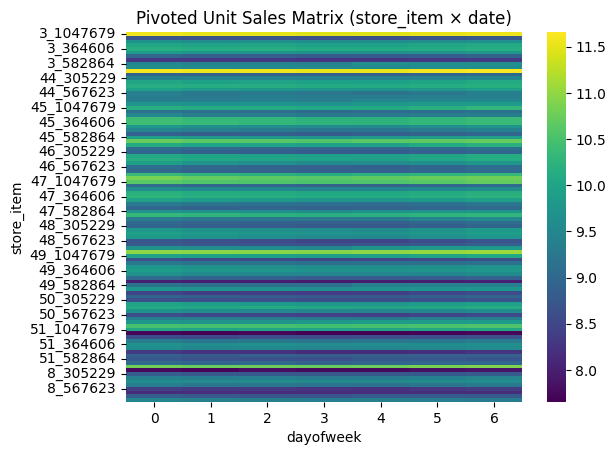

In [56]:
sns.heatmap(pivot_clean, cmap="viridis")
plt.title("Pivoted Unit Sales Matrix (store_item × date)")
plt.show()

In [85]:
pivot_clean.shape

(100, 7)

In [99]:
results_df = compute_spectral_biclustering_row_col_cv_scores(
    data=pivot_clean.values,
    n_clusters_row_range=range(10, 50),
    n_clusters_col_range=range(6, 7),
    cv_folds=3
)
results_df


Evaluating n_row=10, n_col=6
Evaluating n_row=11, n_col=6
Evaluating n_row=12, n_col=6
Evaluating n_row=13, n_col=6
Evaluating n_row=14, n_col=6
Evaluating n_row=15, n_col=6
Evaluating n_row=16, n_col=6
Evaluating n_row=17, n_col=6
Evaluating n_row=18, n_col=6
Evaluating n_row=19, n_col=6
Evaluating n_row=20, n_col=6
Evaluating n_row=21, n_col=6
Evaluating n_row=22, n_col=6
Evaluating n_row=23, n_col=6
Evaluating n_row=24, n_col=6
Evaluating n_row=25, n_col=6
Evaluating n_row=26, n_col=6
Evaluating n_row=27, n_col=6
Evaluating n_row=28, n_col=6
Evaluating n_row=29, n_col=6
Evaluating n_row=30, n_col=6
Evaluating n_row=31, n_col=6
Evaluating n_row=32, n_col=6
Evaluating n_row=33, n_col=6
Evaluating n_row=34, n_col=6
Evaluating n_row=35, n_col=6
Evaluating n_row=36, n_col=6
Evaluating n_row=37, n_col=6
Evaluating n_row=38, n_col=6
Evaluating n_row=39, n_col=6
Evaluating n_row=40, n_col=6
Evaluating n_row=41, n_col=6
Evaluating n_row=42, n_col=6
Evaluating n_row=43, n_col=6
Evaluating n_r

,n_row,n_col,Explained Variance (%),Mean Silhouette,Mean ARI
0,10,6,74.092202,0.249354,NaN
1,11,6,80.730110,0.233316,NaN
2,12,6,76.161976,0.255928,NaN
3,13,6,82.494957,0.268941,NaN
4,14,6,80.799099,0.251132,NaN
5,15,6,84.188548,0.201221,NaN
6,16,6,83.182322,0.260630,NaN
7,17,6,88.798626,0.201403,NaN
8,18,6,85.134022,0.257086,NaN
9,19,6,91.637263,0.266771,NaN


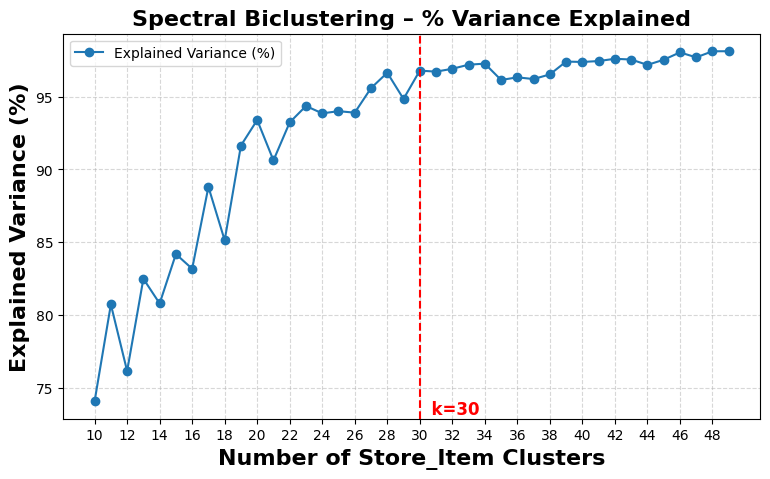

In [112]:
plot_biclustering_elbow(results_df, 
                        title="Spectral Biclustering – % Variance Explained", 
                        x_col="n_row", 
                        metric="Explained Variance (%)", 
                        tick_step=2,
                        vline_x=30,
                        title_fontsize=16,
                        fn="../output/figures/20250604_spectral_biclustering_elbow.tiff")

In [69]:
results_df = compute_gdkm_cv_scores(
    X,
    P_range=range(2, 8),   # Try 2 to 7 row clusters
    Q_range=range(2, 8),   # Try 2 to 7 column clusters
    cv_folds=3             # 3-fold CV
)

In [23]:
# With BIC-like penalty (favors simpler models)
best_pq, best_score = suggest_optimal_pq(results_df, criterion='bic', penalty_lambda=0.5)
print(f"Best (P, Q) by penalized loss: {best_pq} → score = {best_score:.3f}")

Best (P, Q) by penalized loss: (2, 4) → score = 210.768


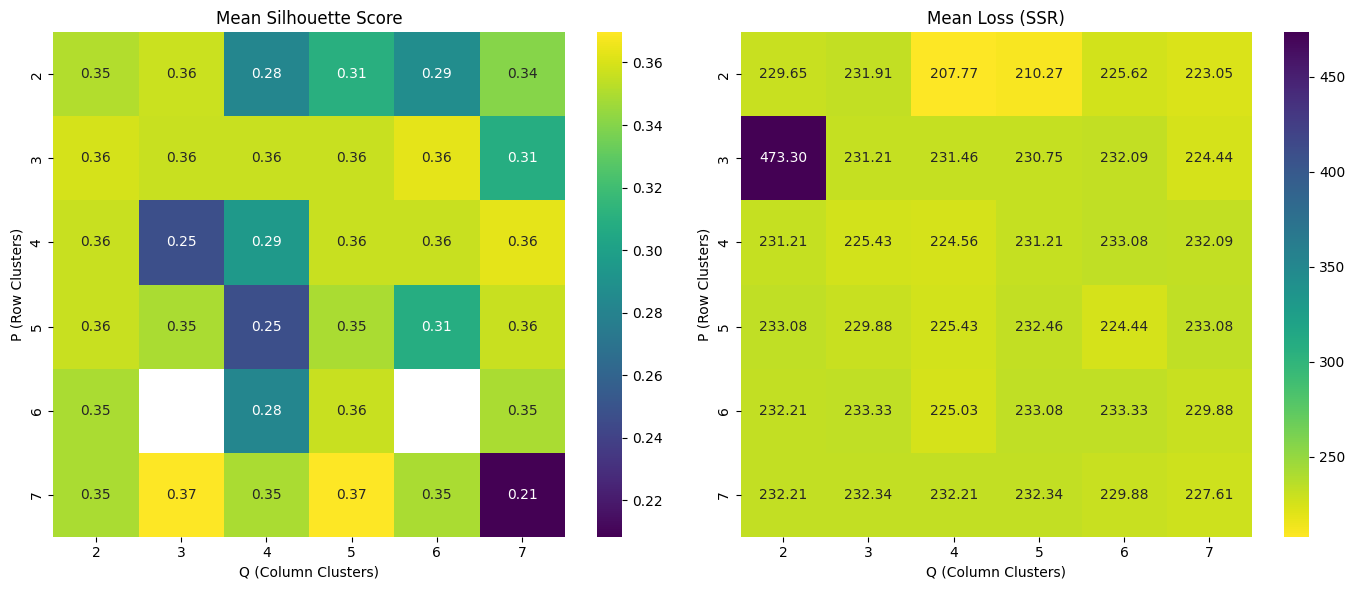

In [24]:
visualize_gdkm_cv_scores(results_df)

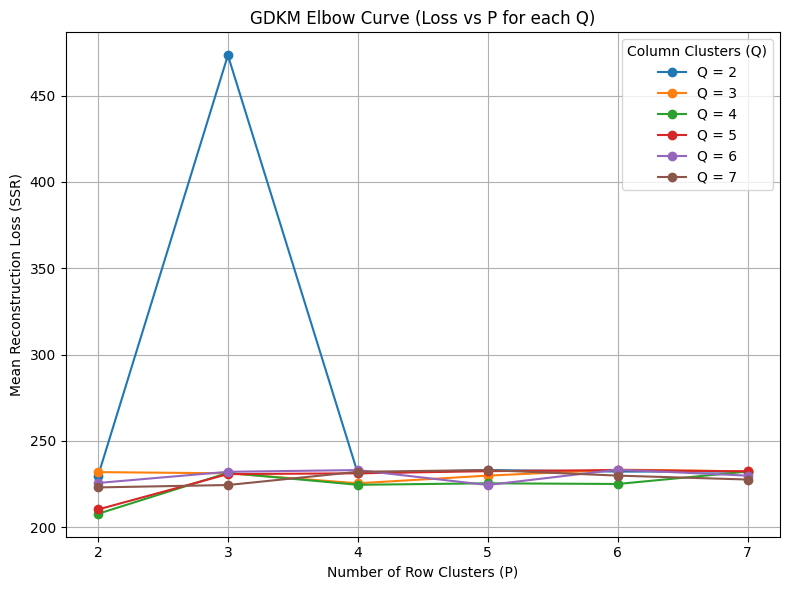

In [25]:
plot_gdkm_elbow_curve(results_df)

In [ ]:

U, V_list, C_blocks, _ = generalized_double_kmeans(
    X, P=4, Q_list=[5]*4, random_state=42
)

visualize_clustered_matrix(X, U, V_list, title="Sales Time-Series Clustering (Preprocessed)")
